In [2]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib 
import numpy as np
import pandas as pd
import os, sys
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    
 
# use LaTeX, choose nice some looking fonts and tweak some settings
matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', 
#               preamble=[r'\usepackage[T1]{fontenc}',
#                         r'\usepackage{amsmath}',
#                         r'\usepackage{txfonts}',
#                         r'\usepackage{textcomp}'])

matplotlib.rc('figure', figsize=(12, 9))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0')

## 머신 러닝 모델의 평가.

- 실제 모델을 평가하기 위해서 데이터를 훈련용, 검증용, 테스트용 이렇게 세 가지로 분리하는 것이 일반적임. 다만 이 책의 목적은 개념 학습이므로 일부 실습에서는 별도로 세 가지로 분리하지 않고 훈련용, 테스트용으로만 분리해서 사용힘.

- 검증용 데이터는 모델의 성능을 평가하기 위한 용도가 아니라, 모델의 성능을 조정하기 위한 용도. 더 정확히는 과적합이 되고 있는지 판단하거나 하이퍼파라미터의 조정을 위한 용도. 

- **하이퍼파라미터(초매개변수)** 란 값에 따라서 모델의 성능에 영향을 주는 매개변수들을 말합니다. 반면, 가중치와 편향과 같은 학습을 통해 바뀌어져가는 변수를 이 책에서는 **매개변수**라고 부른다.

- 하이퍼파라미터와 매개변수의 가장 큰 차이는 하이퍼파라미터는 보통 사용자가 직접 정해줄 수 있는 변수라는 점(선형 회귀 챕터에서 배우게 되는 경사 하강법에서 학습률(learning rate), 딥 러닝에서는 은닉층의 수, 뉴런의 수, 드롭아웃 비율 등) 
- 반면 매개변수는 사용자가 결정해주는 값이 아니라 모델이 학습하는 과정에서 얻어지는 값. 

- 훈련용 데이터로 훈련을 모두 시킨 모델은 검증용 데이터를 사용하여 정확도를 검증하며 하이퍼파라미터를 튜닝(tuning)한다. 또한 이 모델의 매개변수는 검증용 데이터로 정확도가 검증되는 과정에서 점차 검증용 데이터에 점점 맞추어져 가기 시작한다.

## 혼동 행렬(Confusion Matrix)

- 머신 러닝에서는 맞춘 문제수를 전체 문제수로 나눈 값을 정확도(Accuracy)라고 한다. 하지만 정확도는 맞춘 결과와 틀린 결과에 대한 세부적인 내용을 알려주지는 않으므로 **혼동 행렬(Confusion Matrix)** 을 사용한다.

- 예를 들어 양성(Positive)과 음성(Negative)을 구분하는 이진 분류가 있다고 하였을 때 혼동 행렬은 다음과 같습니다. 각 열은 예측값을 나타내며, 각 행은 실제값을 나타냅니다.

|-	|참	|거짓|
|---|:---:|:---:|
|참	|TP	|FN|
|거짓	|FP|	TN|

- 이를 각각 TP(True Positive), TN(True Negative), FP(False Postivie), FN(False Negative)라고 하는데 True는 정답을 맞춘 경우고 False는 정답을 맞추지 못한 경우입니다. 그리고 Positive와 Negative는 각각 제시했던 정답입니다. 즉, TP는 양성(Postive)이라고 대답하였고 실제로 양성이라서 정답을 맞춘 경우입니다. TN은 음성(Negative)이라고 대답하였는데 실제로 음성이라서 정답을 맞춘 경우입니다.

- 그럼 FP는 양성이라고 대답하였는데, 음성이라서 정답을 틀린 경우이며 FN은 음성이라고 대답하였는데 양성이라서 정답을 틀린 경우가 됩니다. 그리고 이 개념을 사용하면 또 새로운 개념인 정밀도(Precision)과 재현률(Recall)이 됩니다.

- 정밀도(Precision)
정밀도은 양성이라고 대답한 전체 케이스에 대한 TP의 비율입니다. 즉, 정밀도를 수식으로 표현하면 다음과 같습니다.

$$
정밀도=\dfrac{TP}{TP+FP}
$$

2) 재현률(Recall)
재현률은 실제값이 양성인 데이터의 전체 개수에 대해서 TP의 비율입니다. 즉, 양성인 데이터 중에서 얼마나 양성인지를 예측(재현)했는지를 나타냅니다.

$$
재현률=\dfrac{TP}{TP+FN}
$$


## 퍼셉트론
- 퍼셉트론(Perceptron)은 프랑크 로젠블라트(Frank Rosenblatt)가 1957년에 제안한 초기 형태의 인공 신경망으로 다수의 입력으로부터 하나의 결과를 내보내는 알고리즘.

<img src="./perceptron.png" width="20%">

- $x=(x_1,\ldots,\,x_n)$ 는 입력값을 의미하며, $W=(W_1,\ldots,\,W_n)$ 는 가중치(Weight), $y$ 는 출력값, 그림 안의 원은 인공 뉴런.

- 각 입력값이 가중치와 곱해져서 인공 뉴런에 보내지고, 각 입력값과 그에 해당되는 가중치의 곱의 전체 합이 임계치(threshold)를 넘으면 종착지에 있는 인공 뉴런은 출력 신호로서 1을 출력하고, 그렇지 않을 경우에는 0을 출력함. 이러한 함수를 계단 함수(Step function)라고 한다. 

- 이때 계단 함수에 사용된 이 임계치값을 수식으로 표현할 때는 보통 세타($\theta$)로 표현한다.
$$
y = 1 \text{ if } \sum_{i=1}^n W_i x_i \ge \theta \,,\\
y = 0 \text{ if } \sum_{i=1}^n W_i x_i > \theta \,.
$$

True

## Pytorch 로 단층 퍼셉트론 구현하기

#### 1개의 뉴런을 가지는 단층 퍼셉트론 구현


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# 이제 XOR 문제에 해당되는 입력과 출력을 정의합니다.
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

# 이제 1개의 뉴런을 가지는 단층 퍼셉트론을 구현해봅시다. 단층 퍼셉트론이 처음 소개되었을 때는 계단 함수였지만, 우리는 이미 또 다른 활성화 함수인 시그모이드 함수를 알고 있으므로 시그모이드 함수를 사용해보겠습니다.
linear = nn.Linear(2, 1, bias=True)
sigmoid = nn.Sigmoid()
model = nn.Sequential(linear, sigmoid).to(device)

# 비용 함수와 옵티마이저 정의
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)

#10,001번의 에포크 수행. 0번 에포크부터 1,000번 에포크까지.
for step in range(1001): 
    optimizer.zero_grad()
    hypothesis = model(X)

    # 비용 함수
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    if step % 100 == 0: # 100번째 에포크마다 비용 출력
        print(step, cost.item())

0 0.7273974418640137
100 0.6931475400924683
200 0.6931471824645996
300 0.6931471824645996
400 0.6931471824645996
500 0.6931471824645996
600 0.6931471824645996
700 0.6931471824645996
800 0.6931471824645996
900 0.6931471824645996
1000 0.6931471824645996


In [5]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('모델의 출력값(Hypothesis): ', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
    print('실제값(Y): ', Y.cpu().numpy())
    print('정확도(Accuracy): ', accuracy.item())


모델의 출력값(Hypothesis):  [[0.5]
 [0.5]
 [0.5]
 [0.5]]
모델의 예측값(Predicted):  [[0.]
 [0.]
 [0.]
 [0.]]
실제값(Y):  [[0.]
 [1.]
 [1.]
 [0.]]
정확도(Accuracy):  0.5


## 인공신경망에서의 순전파와 역전파

#### 1. 인공 신경망의 이해(Neural Network Overview)

- 인공 신경망의 예재를 소개합니다. 역전파의 이해를 위해서 여기서 사용할 인공 신경망은 입력층, 은닉층, 출력층 이렇게 3개의 층을 가집니다. 또한 해당 인공 신경망은 두 개의 입력과, 두 개의 은닉층 뉴런, 두 개의 출력층 뉴런을 사용합니다. 은닉층과 출력층의 모든 뉴런은 활성화 함수로 시그모이드 함수를 사용합니다.

<img src="sample_nn_1.png" width="25%">

위의 그림은 여기서 사용할 인공 신경망의 모습을 보여줍니다. 

- 은닉층과 출력층의 모든 뉴런에서 변수 $z$가 존재하는데 여기서 변수 $z$는 이전층의 모든 입력이 각각의 가중치와 곱해진 값들이 모두 더해진 가중합을 의미한다. 이 값은 뉴런에서 아직 시그모이드 함수를 거치지 않은 상태이다. 즉, 활성화 함수의 입력을 의미한다. 
- $z$ 우측의 $\mid$ 를 지나서 존재하는 변수 $h$ 또는 $o$ 는 $z$가 시그모이드 함수를 지난 후의 값으로 각 뉴런의 출력값을 의미합니다. 
- 이번 역전파 예제에서는 인공 신경망에 존재하는 모든 가중치 $W$에 대해서 역전파를 통해 업데이트하는 것을 목표로합니다. 일단 해당 인공 신경망은 편향 $b$ 는 고려하지 않습니다.

#### 2. 순전파(Forward Propagation)

<img src="./sample_forwardpropagation_1.png" width="30%">

- 주어진 값이 위의 그림과 같을 때 순전파를 진행해봅시다. 파란색 숫자는 입력값을 의미하며, 빨간색 숫자는 각 가중치의 값을 의미합니다. 앞으로 진행하는 계산의 결과값은 소수점 아래 여덟번째 자리까지 반올림하여 표기합니다.

- 각 입력은 입력층에서 은닉층 방향으로 향하면서 각 입력에 해당하는 가중치와 곱해지고, 결과적으로 가중합으로 계산되어 은닉층 뉴런의 시그모이드 함수의 입력값이 됩니다. $z_1$ 과 $z_2$ 는 시그모이드 함수의 입력으로 사용되는 각각의 값에 해당됩니다.

$$
z_1=W_1x_1+W_2x_2=0.3 \times 0.1 + 0.25\times 0.2 = 0.08\,,\\
z_2=W_3x_1+W_4x_2=0.4 \times 0.1 + 0.35 \times 0.2=0.11\,.
$$

- $z_1$ 과 $z_2$ 는 각각의 은닉층 뉴런에서 시그모이드 함수를 지나게 되는데 시그모이드 함수가 리턴하는 결과값은 은닉층 뉴런의 최종 출력값입니다. 식에서는 각각 $h_1$ 과 $h_2$ 에 해당되며, 아래의 결과와 같습니다.

$$
h_1 = \operatorname{sigmoid}(z_1) = 0.51998934 \,,\\
h_2 = \operatorname{sigmoid}(z_2)=0.52747230\,.
$$

- $h_1$ 과 $h_2$ 이 두 값은 다시 출력층의 뉴런으로 향하게 되는데 이때 다시 각각의 값에 해당되는 가중치와 곱해지고, 다시 가중합 되어 출력층 뉴런의 시그모이드 함수의 입력값이 됩니다. 식에서는 각각 $z_3$ 과 $z_4$에 해당됩니다.

$$
z_3= W_ 5 h_1 + W_6 h_2 = 0.45 \times h_1+0.4 \times h_2=0.44498412 \,,\\
z_4= W_7 h_1 + W_8 h_ 2 = 0.7 \times h_1 + 0.6 \times h_2=0.68047592 \,.
$$

- $z_3$ 과 $z_4$ 이 출력층 뉴런에서 시그모이드 함수를 지난 값은 이 인공 신경망이 최종적으로 계산한 출력값입니다. 실제값을 예측하기 위한 값으로서 예측값이라고도 부릅니다.

$$
o_1 = \operatorname{sigmoid}(z_3) = 0.60944600 \,,\\
o_2 = \operatorname{sigmoid}(z_4) = 0.66384491 \,.
$$

- 이제 해야할 일은 예측값과 실제값의 오차를 계산하기 위한 오차 함수를 선택하는 것입니다. 오차(Error)를 계산하기 위한 손실 함수(Loss function)로는 평균 제곱 오차 MSE를 사용합니다. 식에서는 실제값을 $\operatorname{target}$이라고 표현하였으며, 순전파를 통해 나온 예측값을 $\operatorname{output}$으로 표현하였습니다. 그리고 각 오차를 모두 더하면 전체 오차 $E_{total}$가 됩니다.

$$
E_{o1}=\dfrac{1}{2}(\text{target}_{o1}−\text{output}_{o1})^2=0.02193381 \,,\\
E_{o2}=\dfrac{1}{2}(\text{target}_{o2}−\text{output}_{o2})^2=0.00203809\,,\\
E_{total}=E_{o1}+E_{o2}=0.02397190\,.
$$

#### 3. 역전파 1단계(Back Propagation Step 1)

<img src = "./sample_backwardpropagation_1.png" width="40%">

- 순전파가 입력층에서 출력층으로 향한다면 역전파는 반대로 출력층에서 입력층 방향으로 계산하면서 가중치를 업데이트해갑니다. 출력층 바로 이전의 은닉층을 N층이라고 하였을 때, 출력층과 $N$층 사이의 가중치를 업데이트하는 단계를 역전파 1단계, 그리고 $N$층과 $N$층의 이전층 사이의 가중치를 업데이트 하는 단계를 역전파 2단계라고 해봅시다.


- 역전파 1단계에서 업데이트 해야 할 가중치는 $W_5,\,W_6,\,W_7,\,W_8$ 로 총 4개입니다. 원리 자체는 동일하므로 우선 $W_5$에 대해서 먼저 업데이트를 진행해보겠습니다. 경사 하강법을 수행하려면 가중치 $W_5$를 업데이트 하기 위해서 $\dfrac{\partial E_{total}}{\partial W_5}$를 계산해야 합니다.

- $\dfrac{\partial E_{total}}{\partial W_5}$ 를 계산하기 위해 미분의 연쇄 법칙(Chain rule)에 따라서 이와 같이 풀어 쓸 수 있습니다.

$$
\dfrac{\partial E_{total}}{\partial W_5} = \dfrac{\partial E_{total}}{\partial o_1} \times \dfrac{\partial o_1}{\partial z_3} \times \dfrac{\partial z_3}{\partial W_5}
$$

- 위의 식에서 우변의 세 개의 각 항에 대해서 순서대로 계산해봅시다. 우선 첫번째 항에 대해서 계산해보겠습니다. 미분을 진행하기 전에 $E_{total}$의 값을 상기해봅시다. $E_{total}$ 은 앞서 순전파를 진행하고 계산했던 전체 오차값입니다. 식은 다음과 같습니다.


$$
E_{total}=\dfrac{1}{2}\left( \operatorname{target}_{o1} - \operatorname{output}_{o1} \right)^2  + \dfrac{1}{2}\left( \operatorname{target}_{o2} -\operatorname{output}_{o2} \right)^2
$$

이에 $\dfrac{\partial E_{total}}{\partial o_1}$ 는 다음과 같습니다.

$$
\dfrac{\partial E_{total}}{\partial o_1} = 2 \times \dfrac{1}{2} \left( \operatorname{target}_{o1} - \operatorname{output}_{o1} \right)^{2 -1} \times (-1) + 0\,,\\
\dfrac{\partial E_{total}}{\partial o_1} = - \left( \operatorname{target}_{o1}- \operatorname{output}_{o1} \right) = -(0.4 - 0.60944600) = 0.20944600\,.
$$

- 이제 두번째 항을 주목해봅시다. $o_1$ 이라는 값은 시그모이드 함수의 출력값입니다. 그런데 시그모이드 함수 $f(x)=\dfrac{1}{1+e^{-x}}$ 의 미분은 $f'(x) = f(x) \times(1 -f(x))$ 입니다. 앞으로의 계산 과정에서도 계속해서 시그모이드 함수를 미분해야 하는 상황이 생기므로 기억해둡시다. 이에 따라서 두번째 항의 미분 결과는 다음과 같습니다. (시그모이드 함수 미분 참고 링크 : https://en.wikipedia.org/wiki/Logistic_function#Derivative)

$$
\dfrac{\partial o_1}{\partial z_3} = o_1 \times (1 - o_1) = 0.60944600\times (1 - 0.60944600)=0.23802157
$$

- 마지막으로 세번째 항은 $h_1$ 의 값과 동일합니다.

$$
\dfrac{\partial z_3}{\partial W_5}= h_ 1=0.51998934\;.
$$

- 우변의 모든 항을 계산하였습니다. 이제 이 값을 모두 곱해주면 됩니다.

$$
\dfrac{\partial E_{total}}{W_5} = 0.20944600 \times 0.23802157 \times 0.51998934 = 0.02592286\;.
$$

- 이제 앞서 배웠던 경사 하강법을 통해 가중치를 업데이트 할 때가 왔습니다! 하이퍼파라미터에 해당되는 학습률(learning rate) $\alpha$ 는 $0.5$ 라고 가정합니다.

$$
W^+_5=W_5−\alpha \dfrac{\partial E_{total}}{\partial W_5} = 0.45 - 0.5 \times 0.02592286 = 0.43703857\;.
$$

- 이와 같은 원리로 $W^+_6,\, W^+_7,\, W^+_8$을 계산할 수 있습니다.

$$
\dfrac{\partial E_{total}}{\partial W_6}=\dfrac{\partial E_{total}}{\partial o_1} \times \dfrac{\partial o_1}{\partial z_3} \times  \dfrac{\partial z_3}{\partial W_6} \longrightarrow W^+_6 = 0.38685205 \,,\\
\dfrac{\partial E_{total}}{\partial W_7} = \dfrac{\partial E_{total}}{\partial o_2}\times \dfrac{\partial o_2 }{\partial z_4} \times \dfrac{\partial z_4}{\partial W_7} \longrightarrow W^+_7=0.69629578 \,,\\
\dfrac{\partial E_{total}}{\partial W_8} = \dfrac{\partial E_{total}}{\partial o_2} \times  \dfrac{\partial o_2}{\partial z_4} \times  \dfrac{\partial z_4}{\partial W_8} \longrightarrow W^+_8 = 0.59624247\,.
$$

#### 4. 역전파 2단계 (Back Propagation Step 2)

<img src = "./sample_backwardpropagation_2.png" width="40%">

- 1단계를 완료하였다면 이제 입력층 방향으로 이동하며 다시 계산을 이어갑니다. 위의 그림에서 빨간색 화살표는 순전파의 정반대 방향인 역전파의 방향을 보여줍니다. 현재 인공 신경망은 은닉층이 1개밖에 없으므로 이번 단계가 마지막 단계입니다. 하지만 은닉층이 더 많은 경우라면 입력층 방향으로 한 단계씩 계속해서 계산해가야 합니다.

- 이번 단계에서 계산할 가중치는 $W_1,\,W_2,\,W_3,\,W_4$입니다. 원리 자체는 동일하므로 우선 $W_1$에 대해서 먼저 업데이트를 진행해보겠습니다. 경사 하강법을 수행하려면 가중치 $W_1$를 업데이트 하기 위해서 $\dfrac{\partial E_{total}}{\partial W_1}$를 계산해야 합니다.

- $\dfrac{\partial E_{total}}{\partial W_1}$ 를 계산하기 위해 미분의 연쇄 법칙(Chain rule)에 따라서 이와 같이 풀어 쓸 수 있습니다.

$$
\dfrac{\partial E_{total}}{\partial W_1} = \dfrac{\partial E_{total}}{\partial h_1} \times  \dfrac{\partial h_1}{\partial z_1} \times  \dfrac{\partial z_1}{\partial W_1}
$$

- 위의 식에서 우변의 첫번째항인 ∂Etotal∂h1는 다음과 같이 다시 식을 풀어서 쓸 수 있습니다.

$$
\dfrac{\partial E_{total}}{\partial h_1} = \dfrac{\partial E_{o_1}}{\partial h_1}+\dfrac{\partial E_{o2}}{\partial h_1}
$$

- 위의 식의 우변의 두 항을 각각 구해봅시다. 우선 첫번째 항 $\dfrac{\partial E_{o1}}{\partial h_1}$에 대해서 항을 분해 및 계산해보겠습니다.

$$
\begin{align}
\dfrac{\partial E_{o1}}{\partial h_1}&=\dfrac{\partial E_{o1}}{z_3} \times \dfrac{\partial z_3}{\partial h_1} = \dfrac{\partial E_{o1}}{\partial o_1} \times \dfrac{\partial o_1}{\partial z_3} \times \dfrac{\partial z_3}{\partial h_1} \\
&= -(\operatorname{target}_{o1}−\operatorname{output}_{o1}) \times o_1 \times (1 - o_1) \times W_5 \\
&= 0.20944600 \times 0.23802157 \times0.45\\
&=0.02243370\;.
\end{align}
$$

- 이와 같은 원리로 $\dfrac{\partial E_{o2}}{ \partial h_1}$ 또한 구합니다.

$$
\begin{align}
\dfrac{\partial E_{o2}}{\partial h_1} &= \dfrac{\partial E_{o2}}{\partial z_4} \times \dfrac{ \partial z_4}{\partial h_1} = \dfrac{\partial E_{o2}}{\partial o_2} \times  \dfrac{\partial o_2}{\partial z_4}\times \dfrac{\partial z_4}{\partial h_1} = 0.00997311 \,,\\
\dfrac{ \partial E_{total}}{\partial h_1}&=0.02243370+0.00997311=0.03240681\,.
\end{align}
$$

- 이제 $\dfrac{\partial E_{total}}{\partial W_1}$ 를 구하기 위해서 필요한 첫번째 항을 구했습니다. 나머지 두 항에 대해서 구해보도록 하겠습니다.

$$
\begin{align}
\dfrac{\partial h_1}{\partial z_1} &= h_1 \times (1 - h_1) = 0.51998934(1-0.51998934)=0.24960043 \,,\\
\dfrac{\partial z_1}{\partial W_1} &= x_1 = 0.1
\end{align}
$$

- 즉, $\dfrac{\partial E_{total}}{\partial W_1}$ 는 다음과 같습니다.

$$
\dfrac{\partial E_{total}}{\partial W_1}=0.03240681 \times 0.24960043 \times 0.1 = 0.00080888
$$

- 이제 앞서 배웠던 경사 하강법을 통해 가중치를 업데이트 할 수 있습니다.


$$
W^+_1=W_1−\alpha \dfrac{\partial E_{total}}{\partial W_1} = 0.1 - 0.5\times 0.00080888 = 0.29959556
$$

이와 같은 원리로 $W^+_2,\, W^+_3,\, W^+_4$ 을 계산할 수 있습니다.

$$
\begin{align}
\dfrac{\partial E_{total}}{\partial W_2} &= \dfrac{\partial E_{total}}{\partial h_1} \times  \dfrac{\partial h_1}{\partial z_1} \times \dfrac{\partial z_1}{\partial W_2} \longrightarrow W^+_2 = 0.24919112\,,\\
\dfrac{\partial E_{total}}{\partial W_3} &= \dfrac{\partial E_{total}}{\partial h_2}\times \dfrac{\partial h_2} {\partial z_2}\times \dfrac{\partial z_2}{\partial W_3}\longrightarrow W^+_3 = 0.39964496\,,\\
\dfrac{\partial E_{total}}{\partial W_4} &= \dfrac{\partial E_{total}}{\partial h_2} \times  \dfrac{\partial h_2}{\partial z_2} \times \dfrac{\partial z_2}{\partial W_4} \longrightarrow W^+_4 = 0.34928991\,.
\end{align}
$$

<u>인공 신경망의 학습은 오차를 최소화하는 가중치를 찾는 목적으로 순전파와 역전파를 반복하는 것을 말합니다.</u>



## 다층 퍼셉트론으로 XOR 구현하기

In [5]:
torch.cuda.manual_seed_all(777)

# XOR 문제를 풀기 위한 입력과 출력을 정의해줍니다.
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

# 이제 다층 퍼셉트론을 설계합니다. 아래는 입력층, 은닉층1, 은닉층2, 은닉층3, 출력층을 가지는 은닉층이 3개인 인공 신경망입니다.
model = nn.Sequential(
          nn.Linear(2, 10, bias=True), # input_layer = 2, hidden_layer1 = 10
          nn.Sigmoid(),
          nn.Linear(10, 10, bias=True), # hidden_layer1 = 10, hidden_layer2 = 10
          nn.Sigmoid(),
          nn.Linear(10, 10, bias=True), # hidden_layer2 = 10, hidden_layer3 = 10
          nn.Sigmoid(),
          nn.Linear(10, 1, bias=True), # hidden_layer3 = 10, output_layer = 1
          nn.Sigmoid()
          ).to(device)

# 비용 함수와 옵타마이저를 선언합니다. nn.BCELoss()는 이진 분류에서 사용하는 크로스엔트로피 함수입니다.
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)  # modified learning rate from 0.1 to 1

# 총 10,001번의 에포크를 수행합니다. 각 에포크마다 역전파가 수행된다고 보면 되겠습니다.
for epoch in range(10001):
    optimizer.zero_grad()
    # forward 연산
    hypothesis = model(X)

    # 비용 함수
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    # 100의 배수에 해당되는 에포크마다 비용을 출력
#     if epoch % 100 == 0:
#         print(epoch, cost.item())
print(epoch, cost.item())

10000 0.00013882899656891823


In [4]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('모델의 출력값(Hypothesis): ', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
    print('실제값(Y): ', Y.cpu().numpy())
    print('정확도(Accuracy): ', accuracy.item())

모델의 출력값(Hypothesis):  [[1.8572781e-04]
 [9.9975139e-01]
 [9.9973148e-01]
 [3.5759291e-04]]
모델의 예측값(Predicted):  [[0.]
 [1.]
 [1.]
 [0.]]
실제값(Y):  [[0.]
 [1.]
 [1.]
 [0.]]
정확도(Accuracy):  1.0


## 비선형 활성화 함수(Activation function)

#### 1. 활성화 함수의 특징 - 비선형 함수(Nonlinear function)
- 활성화 함수의 특징은 선형 함수가 아닌 비선형 함수여야 한다는 점입니다. 선형 함수란 출력이 입력의 상수배만큼 변하는 함수를 선형함수라고 합니다. 예를 들어 $f(x)=Wx+b$ 라는 함수가 있을 때, $W$와 $b$는 상수입니다. 이 식은 그래프를 그리면 직선이 그려집니다. 반대로 비선형 함수는 직선 1개로는 그릴 수 없는 함수를 말합니다.

- 인공 신경망의 능력을 높이기 위해서는 은닉층을 계속해서 추가해야 합니다. 그런데 만약 활성화 함수로 선형 함수를 사용하게 되면 은닉층을 쌓을 수가 없습니다. 예를 들어 활성화 함수로 선형 함수를 선택하고, 층을 계속 쌓는다고 가정해보겠습니다. 활성화 함수는 $f(x)=Wx$ 라고 가정합니다. 여기다가 은닉층을 두 개 추가한다고하면 출력층을 포함해서 $y(x)=f(f(f(x)))$ 가 됩니다. 이를 식으로 표현하면 $W \times W\times W \times x$ 입니다. 그런데 이는 잘 생각해보면 $W$ 의 세 제곱값을 $k$ 라고 정의해버리면 $y(x)=kx$ 와 같이 다시 표현이 가능합니다. 즉, 선형 함수로는 은닉층을 여러번 추가하더라도 1회 추가한 것과 차이를 줄 수 없습니다.

- 선형 함수를 사용한 은닉층을 1회 추가한 것과 연속으로 추가한 것이 차이가 없다는 뜻이지, 선형 함수를 사용한 층이 아무 의미가 없다는 뜻이 아닙니다. 학습 가능한 가중치가 새로 생긴다는 점에서 분명히 의미가 있습니다. 이와 같이 선형 함수를 사용한 층을 활성화 함수를 사용하는 은닉층과 구분하기 위해서 선형층(linear layer)이나 투사층(projection layer) 등의 다른 표현을 사용하여 표현하기도 합니다. 활성화 함수를 사용하는 일반적인 은닉층을 선형층과 대비되는 표현을 사용하면 비선형층(nonlinear layer)입니다.



#### 2. 시그모이드 함수(Sigmoid function)와 기울기 소실
시그모이드 함수를 사용한 어떤 인공 신경망이 있다고 가정해보겠습니다.

<img src = "./simple-neural-network.png" width="40%">

- 위 인공 신경망의 학습 과정은 다음과 같습니다. 우선 인공 신경망은 입력에 대해서 순전파(forward propagation) 연산을 하고, 그리고 순전파 연산을 통해 나온 예측값과 실제값의 오차를 손실 함수(loss function)을 통해 계산하고, 그리고 이 손실(loss)을 미분을 통해서 기울기(gradient)를 구하고, 이를 통해 역전파(back propagation)를 수행합니다.

- 시그모이드 함수의 문제점은 미분을 해서 기울기(gradient)를 구할 때 발생합니다.


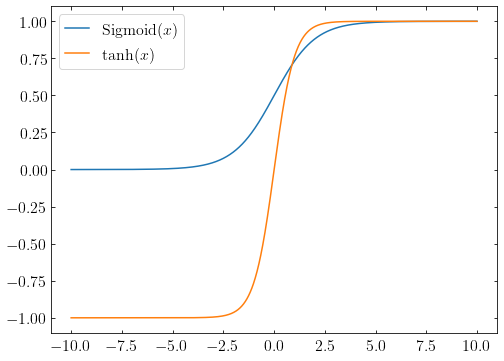

In [11]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

x1=np.arange(-10.0, 10.0, 0.01)
fig=plt.figure(figsize=(8, 6))
plt.plot(x1, sigmoid(x1), label="Sigmoid($x$)")
plt.plot(x1, np.tanh(x1), label="tanh($x$)")
plt.legend()
#plt.grid()

- 위의 그래프는 시그모이드 함수의 그래프를 보여줍니다. 위 그래프를 시그모이드 함수의 출력값이 0 또는 1에 가까워지면, 그래프의 기울기가 완만해지는 모습을 볼 수 있습니다. 기울기가 완만해지는 구간을 주황색, 그렇지 않은 구간을 초록색으로 칠해보겠습니다.
- 주황색 부분은 기울기를 계산하면 0에 가까운 아주 작은 값이 나오게 됩니다. 그런데 역전파 과정에서 0에 가까운 아주 작은 기울기가 곱해지게 되면, 앞단에는 기울기가 잘 전달되지 않게 됩니다. 이러한 현상을 기울기 소실(Vanishing Gradient) 문제라고 합니다.
- 시그모이드 함수를 사용하는 은닉층의 개수가 다수가 될 경우에는 0에 가까운 기울기가 계속 곱해지면 앞단에서는 거의 기울기를 전파받을 수 없게 됩니다. 다시 말해 매개변수 $W$ 가 업데이트 되지 않아 학습이 되지를 않습니다.
- <u>결론적으로 시그모이드 함수를 은닉층에서 사용하는 것은 지양됩니다.</u>

- 하이퍼볼릭탄젠트 함수도 -1과 1에 가까운 출력값을 출력할 때, 시그모이드 함수와 같은 문제가 발생합니다. 그러나 하이퍼볼릭탄젠트 함수의 경우에는 시그모이드 함수와는 달리 0을 중심으로 하고 있는데, 이때문에 시그모이드 함수와 비교하면 반환값의 변화폭이 더 큽니다. 그래서 시그모이드 함수보다는 기울기 소실 증상이 적은 편입니다. 그래서 은닉층에서 시그모이드 함수보다는 많이 사용됩니다.



#### 렐루 함수(ReLU)
- 인공 신경망에서 가장 최고의 인기를 얻고 있는 함수입니다. 수식은 $f(x)=\max(0,x)$ 로 아주 간단합니다.
- 렐루 함수는 음수를 입력하면 0을 출력하고, 양수를 입력하면 입력값을 그대로 반환합니다. 렐루 함수는 특정 양수값에 수렴하지 않으므로 깊은 신경망에서 시그모이드 함수보다 훨씬 더 잘 작동합니다. 뿐만 아니라, 렐루 함수는 시그모이드 함수와 하이퍼볼릭탄젠트 함수와 같이 어떤 연산이 필요한 것이 아니라 단순 임계값이므로 연산 속도도 빠릅니다.
- 하지만 여전히 문제점이 존재하는데, 입력값이 음수면 기울기도 0이 됩니다. 그리고 이 뉴런은 다시 회생하는 것이 매우 어렵습니다. 이 문제를 <u>죽은 렐루(dying ReLU)</u> 라고 합니다.




In [13]:
def relu(x):
    return np.maximum(0, x)

#### 리키 렐루(Leaky ReLU)
- 죽은 렐루를 보완하기 위해 ReLU의 변형 함수들이 등장하기 시작했습니다. 변형 함수는 여러 개가 있지만 여기서는 Leaky ReLU에 대해서만 소개합니다. Leaky ReLU는 입력값이 음수일 경우에 0이 아니라 0.001과 같은 매우 작은 수를 반환하도록 되어있습니다.

- 수식은 $f(x)=\max(ax,x)$ 로 아주 간단합니다. $a$ 는 하이퍼파라미터로 Leaky('새는') 정도를 결정하며 일반적으로는 0.01의 값을 가집니다. 여기서 말하는 '새는 정도'라는 것은 입력값의 음수일 때의 기울기를 비유하고 있습니다.

#### 소프트맥스 함수(Softamx function)
- 은닉층에서 ReLU(또는 ReLU 변형) 함수들을 사용하는 것이 일반적이지만 그렇다고 해서 앞서 배운 시그모이드 함수나 소프트맥스 함수가 사용되지 않는다는 의미는 아닙니다. 분류 문제를 로지스틱 회귀와 소프트맥스 회귀를 출력층에 적용하여 사용합니다.
- 소프트맥스 함수는 시그모이드 함수처럼 출력층의 뉴런에서 주로 사용되는데, 시그모이드 함수가 두 가지 선택지 중 하나를 고르는 이진 분류 (Binary Classification) 문제에 사용된다면 세 가지 이상의 (상호 배타적인) 선택지 중 하나를 고르는 다중 클래스 분류(MultiClass Classification) 문제에 주로 사용됩니다.


#### 참고사항

- 시그모이드 함수의 또 다른 문제점은 원점 중심이 아니라는 점입니다(Not zero-centered). 따라서, 평균이 0이 아니라 0.5이며, 시그모이드 함수는 항상 양수를 출력하기 때문에 출력의 가중치 합이 입력의 가중치 합보다 커질 가능성이 높습니다. 이것을 <u>편향 이동(bias shift)</u>이라 하며, 이러한 이유로 각 레이어를 지날 때마다 분산이 계속 커져 가장 높은 레이어에서는 활성화 함수의 출력이 0이나 1로 수렴하게 되어 기울기 소실 문제가 일어날 수 있습니다.

- 하이퍼볼릭탄젠트 함수는 원점 중심(zero-centered)이기 때문에, 시그모이드와 달리 편향 이동은 일어나지 않습니다. 하지만, 하이퍼볼릭탄젠트 함수 또한 입력의 절대값이 클 경우 -1이나 1로 수렴하게 되는데 시그모이드 함수와 마찬가지로 이때 기울기가 완만해지므로 역시나 기울기 소실 문제가 일어날 수 있습니다.

- 스탠포드 대학교의 딥 러닝 강의 cs231n에서는 ReLU를 먼저 시도해보고, 그다음으로 LeakyReLU나 ELU 같은 ReLU의 변형들을 시도해보며, sigmoid는 사용하지 말라고 권장합니다.

$$
ELU(x) = \left\{\begin{array}{ll} \alpha (\exp (-x) -1) \qquad &\text{if } x>0 \\ x & \text{if } x\le 0 \end{array} \right.
$$

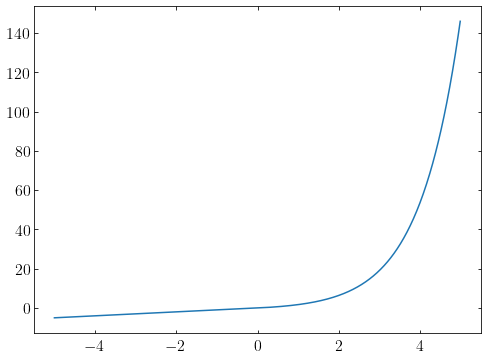

In [20]:
def elu0(x, alpha):
    if x> 0 :
        return alpha*(np.exp(x)-1.)
    else :
        return x
elu = np.vectorize(elu0)
x2=np.arange(-5.0, 5.0, 0.01)
y2 = elu(x2, 1.0)
fig=plt.figure(figsize=(8, 6))
plt.plot(x2, y2)

## 다중 퍼셉트론으로 손글씨 분류하기

In [21]:
from sklearn.datasets import load_digits

In [27]:
digits = load_digits() 
print("The number of total images are {}.".format(len(digits.images)))

The number of total images are 1797.


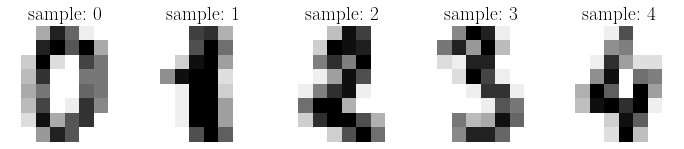

In [28]:
# 상위 5개의 샘플 시각화.

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:5]): # 5개의 샘플만 출력
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('sample: %i' % label)


In [29]:
# 상위 5개 샘플의 레이블을 확인.
for i in range(5):
    print(i,'번 인덱스 샘플의 레이블 : ',digits.target[i])

0 번 인덱스 샘플의 레이블 :  0
1 번 인덱스 샘플의 레이블 :  1
2 번 인덱스 샘플의 레이블 :  2
3 번 인덱스 샘플의 레이블 :  3
4 번 인덱스 샘플의 레이블 :  4


#### 다중 퍼셉트론을 이용한 분류

In [32]:
X = digits.data # 이미지. 즉, 특성 행렬
Y = digits.target # 각 이미지에 대한 레이블

model = nn.Sequential(
    nn.Linear(64, 32), # input_layer = 64, hidden_layer1 = 32
    nn.ReLU(),
    nn.Linear(32, 16), # hidden_layer2 = 32, hidden_layer3 = 16
    nn.ReLU(),
    nn.Linear(16, 10) # hidden_layer3 = 16, output_layer = 10
)
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)
loss_fn = nn.CrossEntropyLoss() # 이 비용 함수는 소프트맥스 함수를 포함하고 있음.
optimizer = optim.Adam(model.parameters())
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    y_pred = model(X) # forwar 연산
    loss = loss_fn(y_pred, Y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, 100, loss.item()))

    losses.append(loss.item())

Epoch    0/100 Cost: 2.334033
Epoch   10/100 Cost: 2.076259
Epoch   20/100 Cost: 1.809229
Epoch   30/100 Cost: 1.510033
Epoch   40/100 Cost: 1.199294
Epoch   50/100 Cost: 0.905360
Epoch   60/100 Cost: 0.659576
Epoch   70/100 Cost: 0.478506
Epoch   80/100 Cost: 0.357277
Epoch   90/100 Cost: 0.277255


In [33]:
model.parameters()

<generator object Module.parameters at 0x7efd7a1bd660>

## 09. 과적합(Overfitting)을 막는 방법들

학습 데이터에 모델이 과적합되는 현상은 모델의 성능을 떨어트리는 주요 이슈입니다. 모델이 과적합되면 훈련 데이터에 대한 정확도는 높을지라도, 새로운 데이터. 즉, 검증 데이터나 테스트 데이터에 대해서는 제대로 동작하지 않습니다. 이는 모델이 학습 데이터를 불필요할 정도로 과하게 암기하여 훈련 데이터에 포함된 노이즈까지 학습한 상태라고 해석할 수 있습니다. 이번 챕터에서는 모델의 과적합을 막을 수 있는 여러가지 방법에 대해서 논의합니다.

#### 1) 데이터의 양을 늘리기
- 모델은 데이터의 양이 적을 경우, 해당 데이터의 특정 패턴이나 노이즈까지 쉽게 암기하게 되므로 과적합 현상이 발생할 확률이 늘어납니다. 그렇기 때문에 데이터의 양을 늘릴 수록 모델은 데이터의 일반적인 패턴을 학습하여 과적합을 방지할 수 있습니다.

- 만약, 데이터의 양이 적을 경우에는 의도적으로 기존의 데이터를 조금씩 변형하고 추가하여 데이터의 양을 늘리기도 하는데 이를 데이터 증식 또는 증강(Data Augmentation)이라고 합니다. 이미지의 경우에는 데이터 증식이 많이 사용되는데 이미지를 돌리거나 노이즈를 추가하고, 일부분을 수정하는 등으로 데이터를 증식시킵니다.

#### 2) 모델의 복잡도 줄이기
- 인공 신경망의 복잡도는 은닉층(hidden layer)의 수나 매개변수의 수 등으로 결정됩니다. 과적합 현상이 포착되었을 때, 인공 신경망 모델에 대해서 할 수 있는 한 가지 조치는 인공 신경망의 복잡도를 줄이는 것 입니다. 
- 인공 신경망에서는 모델에 있는 매개변수들의 수를 모델의 수용력(capacity)이라고 하기도 합니다.

#### 3) 가중치 규제(Regularization) 적용하기

- 잡한 모델이 간단한 모델보다 과적합될 가능성이 높습니다. 그리고 간단한 모델은 적은 수의 매개변수를 가진 모델을 말합니다. 복잡한 모델을 좀 더 간단하게 하는 방법으로 **가중치 규제(Regularizaiton)** 가 있습니다.

  1. L1 규제 : 가중치 $w$들의 절대값 합계를 비용 함수에 추가합니다. L1 노름이라고도 합니다.
  2. L2 규제 : 모든 가중치 $w$들의 제곱합을 비용 함수에 추가합니다. L2 노름이라고도 합니다.

- L1 규제는 기존의 비용 함수에 모든 가중치에 대해서 $\lambda |w|$ 를 더 한 값을 비용 함수로 하고, L2 규제는 기존의 비용 함수에 모든 가중치에 대해서 $\dfrac{1}{2}\lambda w^2$를 더 한 값을 비용 함수로 합니다. $\lambda$ 는 규제의 강도를 정하는 하이퍼파라미터입니다. $\lambda$ 가 크다면 모델이 훈련 데이터에 대해서 적합한 매개 변수를 찾는 것보다 규제를 위해 추가된 항들을 작게 유지하는 것을 우선한다는 의미가 됩니다.

- 이 두 식 모두 비용 함수를 최소화하기 위해서는 가중치 $w$ 들의 값이 작아져야 한다는 특징이 있습니다. L1 규제로 예를 들어봅시다. L1 규제를 사용하면 비용 함수가 최소가 되게 하는 가중치와 편향을 찾는 동시에 가중치들의 절대값의 합도 최소가 되어야 합니다. 이렇게 되면, 가중치 $w$의 값들은 0 또는 0에 가까이 작아져야 하므로 어떤 특성들은 모델을 만들 때 거의 사용되지 않게 됩니다.

- 예를 들어 $H(x)=w_1x_1+w_2x_2+w_3x_3+w_4x_4$ 라는 수식이 있다고 해봅시다. 여기에 L1 규제를 사용하였더니, $w_3$의 값이 0이 되었다고 해봅시다. 이는 $x_3$ 특성은 사실 모델의 결과에 별 영향을 주지 못하는 특성임을 의미합니다.

- L2 규제는 L1 규제와는 달리 가중치들의 제곱을 최소화하므로 $w$ 의 값이 완전히 0이 되기보다는 0에 가까워지기는 경향을 띕니다. <u>L1 규제는 어떤 특성들이 모델에 영향을 주고 있는지를 정확히 판단하고자 할 때 유용합니다. 만약, 이런 판단이 필요없다면 경험적으로는 L2 규제가 더 잘 동작하므로 L2 규제를 더 권장합니다.</u> 인공 신경망에서 L2 규제는 가중치 감쇠(weight decay)라고도 부릅니다.

- 파이토치에서는 옵티마이저의 weight_decay 매개변수를 설정하므로서 L2 규제를 적용합니다. weight_decay 매개변수의 기본값은 0입니다. weight_decay 매개변수에 다른 값을 설정할 수도 있습니다.

~~~
model = Architecture1(10, 20, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
~~~

- 책에 따라서는 Regularization를 정규화로 번역하기도 하지만, 이는 정규화(Normalization)와 혼동될 수 있으므로 규제 또는 정형화라는 번역이 바람직한 것 같습니다. 정규화에 대한 설명은 링크 : http://blog.naver.com/angryking/221330145300 를 참고.

- 인공 신경망에서 정규화(Normalization)라는 용어가 쓰이는 기법으로는 또 배치 정규화, 층 정규화 등이 있습니다.

#### 4) 드롭아웃(Dropout)
- 드롭아웃은 학습 과정에서 신경망의 일부를 사용하지 않는 방법입니다. 예를 들어 드롭아웃의 비율을 0.5로 한다면 학습 과정마다 랜덤으로 절반의 뉴런을 사용하지 않고, 절반의 뉴런만을 사용합니다.

- 드롭아웃은 신경망 학습 시에만 사용하고, 예측 시에는 사용하지 않는 것이 일반적입니다. 학습 시에 인공 신경망이 특정 뉴런 또는 특정 조합에 너무 의존적이게 되는 것을 방지해주고, 매번 랜덤 선택으로 뉴런들을 사용하지 않으므로 서로 다른 신경망들을 앙상블하여 사용하는 것 같은 효과를 내어 과적합을 방지합니다.



## 10. 기울기 소실(Gradient Vanishing)과 폭주(Exploding)

- 깊은 인공 신경망을 학습하다보면 역전파 과정에서 입력층으로 갈 수록 기울기(Gradient)가 점차적으로 작아지는 현상이 발생할 수 있습니다. 입력층에 가까운 층들에서 가중치들이 업데이트가 제대로 되지 않으면 결국 최적의 모델을 찾을 수 없게 됩니다. 이를 기울기 소실(Gradient Vanishing)이라고 합니다.

- 반대의 경우도 있습니다. 기울기가 점차 커지더니 가중치들이 비정상적으로 큰 값이 되면서 결국 발산되기도 합니다. 이를 기울기 폭주(Gradient Exploding)이라고 하며, 뒤에서 배울 순환 신경망(Recurrent Neural Network, RNN)에서 발생할 수 있습니다.

- 이번 챕터에서는 기울기 소실 또는 기울기 폭주를 막는 방법들에 대해서 다룹니다.

#### 1) ReLU와 ReLU의 변형들
- 앞에서 배운 내용을 간단히 복습해봅시다. 시그모이드 함수를 사용하면 입력의 절대값이 클 경우에 시그모이드 함수의 출력값이 0 또는 1에 수렴하면서 기울기가 0에 가까워집니다. 그래서 역전파 과정에서 전파 시킬 기울기가 점차 사라져서 입력층 방향으로 갈 수록 제대로 역전파가 되지 않는 기울기 소실 문제가 발생할 수 있습니다.

- 기울기 소실을 완화하는 가장 간단한 방법은 은닉층의 활성화 함수로 시그모이드나 하이퍼볼릭탄젠트 함수 대신에 ReLU나 ReLU의 변형 함수와 같은 Leaky ReLU를 사용하는 것입니다.

   - 은닉층에서는 시그모이드 함수를 사용하지 마세요.
   - Leaky ReLU를 사용하면 모든 입력값에 대해서 기울기가 0에 수렴하지 않아 죽은 ReLU 문제를 해결합니다.
   - 은닉층에서는 ReLU나 Leaky ReLU와 같은 ReLU 함수의 변형들을 사용하세요.

#### 2) 가중치 초기화(Weight initialization)

- 같은 모델을 훈련시키더라도 가중치가 초기에 어떤 값을 가졌느냐에 따라서 모델의 훈련 결과가 달라지기도 합니다. 다시 말해 가중치 초기화만 적절히 해줘도 기울기 소실 문제과 같은 문제를 완화시킬 수 있습니다.

<b>1. 세이비어 초기화(Xavier Initialization)</b>

논문 : http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

- 2010년 세이비어 글로럿과 요슈아 벤지오는 가중치 초기화가 모델에 미치는 영향을 분석하여 새로운 초기화 방법을 제안했습니다. 이 초기화 방법은 제안한 사람의 이름을 따서 세이비어(Xavier Initialization) 초기화 또는 글로럿 초기화(Glorot Initialization)라고 합니다.

- 이 방법은 균등 분포(Uniform Distribution) 또는 정규 분포(Normal distribution)로 초기화 할 때 두 가지 경우로 나뉘며, 이전 층의 뉴런 개수와 다음 층의 뉴런 개수를 가지고 식을 세웁니다. 이전 층의 뉴런의 개수를 $n_{in}$, 다음 층의 뉴런의 개수를 $n_{out}$ 이라고 해봅시다.

- 글로럿과 벤지오의 논문에서는 균등 분포를 사용하여 가중치를 초기화할 경우 다음과 같은 균등 분포 범위를 사용하라고 합니다.

$$
W \sim \operatorname{Uniform} \left(- \sqrt{\dfrac{6}{n_{in}+n_{out}}},\, +\sqrt{\dfrac{6}{n_{in}+n_{out}}}\right)
$$

- 다시 말해 $m=\sqrt{\dfrac{6}{n_{in}+n_{out}}}$ 일 때,  $-m$과 $+m$ 사이의 균등 분포를 의미합니다. 정규 분포로 초기화할 경우에는 평균이 $0$이고, 표준 편차 $\sigma$ 가 다음을 만족하도록 합니다.
$$
\sigma=\sqrt{\dfrac{2}{n_{in}+n_{out}}}
$$

- 세이비어 초기화는 여러 층의 기울기 분산 사이에 균형을 맞춰서 특정 층이 너무 주목을 받거나 다른 층이 뒤쳐지는 것을 막습니다. 그런데 <u>세이비어 초기화는 시그모이드 함수나 하이퍼볼릭 탄젠트 함수와 같은 S자 형태인 활성화 함수와 함께 사용할 경우에는 좋은 성능을 보이지만, ReLU와 함께 사용할 경우에는 성능이 좋지 않습니다.</u> ReLU 함수 또는 ReLU의 변형 함수들을 활성화 함수로 사용할 경우에는 다른 초기화 방법을 사용하는 것이 좋은데, 이를 He 초기화(He initialization)라고 합니다.

<b>2. He 초기화(He initialization)</b>

논문 : https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf

- He 초기화(He initialization)는 세이비어 초기화와 유사하게 정규 분포와 균등 분포 두 가지 경우로 나뉩니다. 다만, He 초기화는 세이비어 초기화와 다르게 다음 층의 뉴런의 수를 반영하지 않습니다. 전과 같이 이전 층의 뉴런의 개수를 $n_{in}$ 이라고 해봅시다.

- He 초기화는 균등 분포로 초기화 할 경우에는 다음과 같은 균등 분포 범위를 가지도록 합니다.

$$
W \sim \operatorname{Uniform}\left( -\sqrt{\dfrac{6}{n_{in}}},\,  +\sqrt{\dfrac{6}{n_{in}}} \right)
$$

- 정규 분포로 초기화할 경우에는 표준 편차 σ가 다음을 만족하도록 합니다.

$$
\sigma=\sqrt{\dfrac{2}{n_{in}}}
$$

   - 시그모이드 함수나 하이퍼볼릭탄젠트 함수를 사용할 경우에는 세이비어 초기화 방법이 효율적입니다.
   - ReLU 계열 함수를 사용할 경우에는 He 초기화 방법이 효율적입니다.
   - ReLU + He 초기화 방법이 좀 더 보편적입니다.


#### 3) 배치 정규화(Batch Normalization)

- ReLU 계열의 함수와 He 초기화를 사용하는 것만으로도 어느 정도 기울기 소실과 폭주를 완화시킬 수 있지만, 이 두 방법을 사용하더라도 훈련 중에 언제든 다시 발생할 수 있습니다. 기울기 소실이나 폭주를 예방하는 또 다른 방법은 배치 정규화(Batch Normalization)입니다. 배치 정규화는 인공 신경망의 각 층에 들어가는 입력을 평균과 분산으로 정규화하여 학습을 효율적으로 만듭니다.

<b>1. 내부 공변량 변화(Internal Covariate Shift) </b>

- 배치 정규화를 이해하기 위해서는 내부 공변량 변화(Internal Covariate Shift)를 이해할 필요가 있습니다. 내부 공변량 변화란 학습 과정에서 층 별로 입력 데이터 분포가 달라지는 현상을 말합니다. 이전 층들의 학습에 의해 이전 층의 가중치 값이 바뀌게 되면, 현재 층에 전달되는 입력 데이터의 분포가 현재 층이 학습했던 시점의 분포와 차이가 발생합니다. 배치 정규화를 제안한 논문에서는 기울기 소실/폭주 등의 딥 러닝 모델의 불안전성이 층마다 입력의 분포가 달라지기 때문이라고 주장합니다.

   - 공변량 변화는 훈련 데이터의 분포와 테스트 데이터의 분포가 다른 경우를 의미합니다.
   - 내부 공변량 변화는 신경망 층 사이에서 발생하는 입력 데이터의 분포 변화를 의미합니다.

<b>2. 배치 정규화(Batch Normalization)</b>

- 배치 정규화(Batch Normalization)는 표현 그대로 한 번에 들어오는 배치 단위로 정규화하는 것을 말합니다. 배치 정규화는 각 층에서 활성화 함수를 통과하기 전에 수행됩니다. 배치 정규화를 요약하면 다음과 같습니다. 입력에 대해 평균을 0으로 만들고, 정규화를 합니다. 그리고 정규화 된 데이터에 대해서 스케일과 시프트를 수행합니다. 이 때 두 개의 매개변수 $\gamma$ 와 $\beta$ 를 사용하는데, $\gamma$ 는 스케일을 위해 사용하고, $\beta$ 는 시프트를 하는 것에 사용하며 다음 레이어에 일정한 범위의 값들만 전달되게 합니다.

배치 정규화의 수식은 다음과 같습니다. 아래에서 $BN$은 배치 정규화를 의미합니다.

  - $\operatorname{Input}$ : 미니 배치 $B=\{ x^{(1)},\,x^{(2)},\ldots,\,x^{(m)}\}$
  - $\operatorname{Output}$ : $y^{(i)}=BN_{\gamma,\,\beta} (x(i))$

$\mu_B \longleftarrow \dfrac{1}{m}\sum_i x^{(i)}$  # 미니 배치에 대한 평균

$\sigma^2_B  \longleftarrow \dfrac{1}{m} \sum_i \left( x^{(i)} - \mu_B \right)^2$  # 미니 배치에 대한 분산

$\hat{x}^{(i)} \longleftarrow \dfrac{x^{(i)} - \mu_B}{\sqrt{\sigma_B^2+\varepsilon}}$  # 정규화

$y^{(i)} \longleftarrow  \gamma \hat{x}^{(i)} + \beta = BN_{\gamma,\,\beta} \left( x^{(i)} \right)$ # 스케일 조정과 시프트

   - $m$ 은 미니 배치에 있는 샘플의 수
   - $\mu_B$ 는 미니 배치 $B$ 에 대한 평균.
   - $\sigma_B$ 는 미니 배치 $B$에 대한 표준편차.
   - $\hat{x}^{(i)}$ 은 평균이 0이고 정규화 된 입력 데이터.
   - $\varepsilon$ 은 분모가 0이 되는 것을 막는 작은 수. 보편적으로 $10^−5$.
   - $\gamma$ 는 정규화 된 데이터에 대한 스케일 매개변수로 학습 대상
   - $\beta$ 는 정규화 된 데이터에 대한 시프트 매개변수로 학습 대상
   - $y^{(i)}$ 는 스케일과 시프트를 통해 조정한 $BN$의 최종 결과
   
   
- 배치 정규화는 학습 시 배치 단위의 평균과 분산들을 차례대로 받아 이동 평균과 이동 분산을 저장해놓았다가 테스트 할 때는 해당 배치의 평균과 분산을 구하지 않고 구해놓았던 평균과 분산으로 정규화를 합니다.

   - 배치 정규화를 사용하면 시그모이드 함수나 하이퍼볼릭탄젠트 함수를 사용하더라도 기울기 소실 문제가 크게 개선됩니다.
   - 가중치 초기화에 훨씬 덜 민감해집니다.
   - 훨씬 큰 학습률을 사용할 수 있어 학습 속도를 개선시킵니다.
   - 미니 배치마다 평균과 표준편차를 계산하므로 훈련 데이터에 일종의 잡음을 넣는 부수 효과로 과적합을 방지하는 효과도 냅니다. 하지만 부수적 효과이므로 드롭 아웃과 함께 사용하는 것이 좋습니다.
   - 배치 정규화는 모델을 복잡하게 하며, 추가 계산을 하는 것이므로 테스트 데이터에 대한 예측 시에 실행 시간이 느려집니다. 그래서 서비스 속도를 고려하는 관점에서는 배치 정규화가 꼭 필요한지 고민이 필요합니다.
   - 배치 정규화의 효과는 굉장하지만 내부 공변량 변화때문은 아니라는 논문도 있습니다. : https://arxiv.org/pdf/1805.11604.pdf


<b>3) 배치 정규화의 한계 </b>
배치 정규화는 뛰어난 방법이지만 몇 가지 한계가 존재합니다.

- 1. 미니 배치 크기에 의존적이다.
배치 정규화는 너무 작은 배치 크기에서는 잘 동작하지 않을 수 있습니다. 단적으로 배치 크기를 1로 하게되면 분산은 0이 됩니다. 작은 미니 배치에서는 배치 정규화의 효과가 극단적으로 작용되어 훈련에 악영향을 줄 수 있습니다. 배치 정규화를 적용할때는 작은 미니 배치보다는 크기가 어느정도 되는 미니 배치에서 하는 것이 좋습니다. 이처럼 배치 정규화는 배치 크기에 의존적인 면이 있습니다.

- 2. RNN에 적용하기 어렵다.
뒤에서 배우겠지만, RNN은 각 시점(time step)마다 다른 통계치를 가집니다. 이는 RNN에 배치 정규화를 적용하는 것을 어렵게 만듭니다. RNN에서 배치 정규화를 적용하기 위한 몇 가지 논문이 제시되어 있지만, 여기서는 이를 소개하는 대신 배치 크기에도 의존적이지 않으며, RNN에도 적용하는 것이 수월한 층 정규화(layer normalization)라는 방법을 소개하고자 합니다.

## 5. 층 정규화(Layer Normalization)
층 정규화를 이해하기에 앞서 배치 정규화를 시각화해보겠습니다. 다음은 m이 3이고, 특성의 수가 4일 때의 배치 정규화를 보여줍니다. 미니 배치란 동일한 특성(feature) 개수들을 가진 다수의 샘플들을 의미함을 상기합시다.